In [2]:
# load required libraries & modules
%load_ext autoreload
%autoreload 2

import os
from tqdm.notebook import tqdm
import pprint
import time
import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch

from utils import *
from loaddata import *
from visualization_original import *
from rrcapsnet_original import *

torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False)

DATA_DIR = '../data'
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')

BATCHSIZE = 1000

PATH_MNISTC = '../data/MNIST_C/'
CORRUPTION_TYPES = ['identity', 
         'shot_noise', 'impulse_noise','glass_blur','motion_blur',
         'shear', 'scale',  'rotate',  'brightness',  'translate',
         'stripe', 'fog','spatter','dotted_line', 'zigzag',
         'canny_edges']

N_MINI_PER_CORRUPTION = 1000

# general helper funtions for model testing
def load_model(args):
    # load model
    model = RRCapsNet(args).to(args.device) 
    model.load_state_dict(torch.load(args.load_model_path))
    return model

def load_args(load_model_path, args_to_update, verbose=False):
    params_filename = os.path.dirname(load_model_path) + '/params.txt'
    assert os.path.isfile(params_filename), "No param flie exists"
    args = parse_params_wremove(params_filename, removelist = ['device']) 
    args = update_args(args, args_to_update)
    args.load_model_path = load_model_path
    if verbose:
        pprint.pprint(args.__dict__, sort_dicts=False)
    return args

def test_model(task, model, args, verbose=False):
    # set task and print setting
    if verbose:
        pprint.pprint(args.__dict__, sort_dicts=False)
    
    # get test results
    model.eval()
    test_dataloader = fetch_dataloader(task, DATA_DIR, DEVICE, BATCHSIZE, train=False)
    test_loss, test_loss_class, test_loss_recon, test_acc = test(model, test_dataloader, args, acc_name="dynamic")
    if verbose:
        print("==> test_loss=%.5f, test_loss_class=%.5f, test_loss_recon=%.5f, test_acc=%.4f"
              % (test_loss, test_loss_class, test_loss_recon, test_acc))
    return test_loss, test_loss_class, test_loss_recon, test_acc

# helper funtions for model testing on mnist-C
def test_model_mnistc(path_mnistc, corruptionlist, model, verbose=False):
    # set task and print setting
    if verbose:
        pprint.pprint(args.__dict__, sort_dicts=False)
    
    # get average test results over corruptionlist   
    losses, classlosses, reconlosses, accs = [], [], [], []
    for corruption in corruptionlist:
        test_loss, test_loss_class, test_loss_recon, test_acc = test_model_on_each_corruption(path_mnistc, corruption, model, verbose)

        losses.append(test_loss)
        classlosses.append(test_loss_class)
        reconlosses.append(test_loss_recon)
        accs.append(test_acc)
    
    avgtest_loss = sum(losses)/len(corruptionlist)
    avgtest_loss_class = sum(classlosses)/len(corruptionlist)
    avgtest_loss_recon = sum(reconlosses)/len(corruptionlist)
    avgtest_acc = sum(accs)/len(corruptionlist)
    
    if verbose:
        print("==> average test_loss=%.5f, test_loss_class=%.5f, test_loss_recon=%.5f, test_acc=%.4f"
              % (avgtest_loss, avgtest_loss_class, avgtest_loss_recon, avgtest_acc))
        
    return avgtest_loss, avgtest_loss_class, avgtest_loss_recon, avgtest_acc
    
def test_model_on_each_corruption(path_mnistc, corruption, model, verbose=False):
    path_images = os.path.join(path_mnistc, corruption, 'test_images.npy')
    path_labels = os.path.join(path_mnistc, corruption, 'test_labels.npy')

    # convert to torch
    images = np.load(path_images)
    labels = np.load(path_labels)
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    # print(images_tensorized.shape) #torch.Size([10000, 1, 28, 28])
    # print(labels_tensorized.shape) #torch.Size([10000, 10])

    # create dataloader
    kwargs = {'num_workers': 1, 'pin_memory': True} if DEVICE == 'cuda' else {}
    dataset = TensorDataset(images_tensorized, labels_tensorized)
    dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=False, drop_last=False, **kwargs)

    # test on the dataloder
    model.eval()
    test_loss, test_loss_class, test_loss_recon, test_acc = test(model, dataloader, args, acc_name="dynamic")

    if verbose:
        print("==> individual test_loss=%.5f, test_loss_class=%.5f, test_loss_recon=%.5f, test_acc=%.4f"
              % (test_loss, test_loss_class, test_loss_recon, test_acc))
    return test_loss, test_loss_class, test_loss_recon, test_acc



@torch.no_grad()
def evaluate_on_batch(task, batchnum, model, args, train=False, verbose=True, onlyacc=False):
    
    # evaluate on one train/test batch 
    model.eval()
    
    if task == 'mnist_recon':
        # for mnist recon data, it has erased input(x) and intact input (gtx)
        if train:
            dataloader, val_dataloader = fetch_dataloader(task, DATA_DIR, DEVICE, BATCHSIZE, train)
        else:
            dataloader = fetch_dataloader(task, DATA_DIR, DEVICE, BATCHSIZE, train)            
        diter = iter(dataloader)
        for i in range(batchnum):
            x, gtx, y = next(diter)
    else:
        dataloader = fetch_dataloader(task, DATA_DIR, DEVICE, BATCHSIZE, train)    
        diter = iter(dataloader)
        for i in range(batchnum):
            x, y = next(diter)
            gtx = None
            
            
    # attach forward hooks for intermediate outputs for visualizations
    outputs = {}
    
    # from model main output
    x_input_step = []; x_mask_step = []; objcaps_step = []
    
    # from model dynamic routing
    coups_step = []; betas_step= []; rscores_step=[]; recon_coups_step=[] 
    outcaps_len_step=[]; outcaps_len_before_step=[]

    def get_attention_outputs():
        def hook(model, input, output):
            x_mask_step.append(output[0].detach())
            x_input_step.append(output[1].detach())
        return hook

    def get_capsule_outputs():
        def hook(model, input, output):
            objcaps_step.append(output[0].detach())
            coups_step.append(torch.stack(output[1]['coups'], dim=1))
            betas_step.append(torch.stack(output[1]['betas'], dim=1)) 
            if 'rscores' in output[1].keys():
                rscores_step.append(torch.stack(output[1]['rscores'], dim=1))
            if 'recon_coups' in output[1].keys():
                recon_coups_step.append(torch.stack(output[1]['recon_coups'], dim=1))
            if 'outcaps_len' in output[1].keys():
                outcaps_len_step.append(torch.stack(output[1]['outcaps_len'], dim=1))
            if 'outcaps_len_before' in output[1].keys():
                outcaps_len_before_step.append(torch.stack(output[1]['outcaps_len_before'], dim=1))
        return hook
    

    hook1 = model.input_window.register_forward_hook(get_attention_outputs())
    hook2 = model.capsule_routing.register_forward_hook(get_capsule_outputs())
    
    # evaluate and detach hooks
    losses, acc, objcaps_len_step, x_recon_step = evaluate(model, x, y, args, acc_name='dynamic', gtx=gtx)
    hook1.remove()
    hook2.remove()
    
    # add tensor outputs dictionary
    outputs['x_input'] = torch.stack(x_input_step, dim=1)
    outputs['x_mask'] = torch.stack(x_mask_step, dim=1)
    outputs['objcaps'] = torch.stack(objcaps_step, dim=1)
    
    outputs['coups'] = torch.stack(coups_step, dim=1)
    outputs['betas'] = torch.stack(betas_step, dim=1)
    if rscores_step:
        outputs['rscores'] = torch.stack(rscores_step, dim=1)
    if recon_coups_step:
        outputs['recon_coups'] = torch.stack(recon_coups_step, dim=1)
    if outcaps_len_step:
        outputs['outcaps_len'] = torch.stack(outcaps_len_step, dim=1)
    if outcaps_len_before_step:
        outputs['outcaps_len_before'] = torch.stack(outcaps_len_before_step, dim=1)        
    if verbose:
        print("==> On this sigle test batch: test_loss=%.5f, test_loss_class=%.5f, test_loss_recon=%.5f, test_acc=%.4f"
              % (losses[0], losses[1], losses[2], acc))
    
    if onlyacc:
        return acc
    else:
        return x, gtx, y, objcaps_len_step, x_recon_step, outputs
    
    
@torch.no_grad()
def evaluate_model_on_mnistc_mini(corruption, model, args, train=False, verbose=True, save_hooks=False, max_batch_num=None):
    
    # get corruption batch information
    corruption_id = int(CORRUPTION_TYPES.index(corruption))
    num_batch_required = int(N_MINI_PER_CORRUPTION/BATCHSIZE) # if batchsize 100; 10 batches are requried
    
    # load dataloader and iterator
    dataloader = fetch_dataloader('mnist_c_mini', DATA_DIR, DEVICE, BATCHSIZE, train)    
    diter = iter(dataloader)

    if save_hooks:
        def get_attention_outputs():
            def hook(model, input, output):
                x_mask_step.append(output[0].detach())
                x_input_step.append(output[1].detach())
            return hook

        def get_capsule_outputs():
            def hook(model, input, output):
                objcaps_step.append(output[0].detach())
                coups_step.append(torch.stack(output[1]['coups'], dim=1))
                betas_step.append(torch.stack(output[1]['betas'], dim=1)) 
                if 'rscores' in output[1].keys():
                    rscores_step.append(torch.stack(output[1]['rscores'], dim=1))
                if 'recon_coups' in output[1].keys():
                    recon_coups_step.append(torch.stack(output[1]['recon_coups'], dim=1))
                if 'outcaps_len' in output[1].keys():
                    outcaps_len_step.append(torch.stack(output[1]['outcaps_len'], dim=1))
                if 'outcaps_len_before' in output[1].keys():
                    outcaps_len_before_step.append(torch.stack(output[1]['outcaps_len_before'], dim=1))
            return hook
        
        outputs = {}

        x_input_step_all = []; x_mask_step_all = []; objcaps_step_all = []

        coups_step_all = []; betas_step_all= []; rscores_step_all=[]; recon_coups_step_all=[] 
        outcaps_len_step_all=[]; outcaps_len_before_step_all=[]

    x_all, y_all, gtx_all, loss_all, acc_all, objcaps_len_step_all, x_recon_step_all = [],[],[],[],[],[],[]
    model.eval()        
    # get input and gt
    for i in range(corruption_id*num_batch_required): #id =0, 0 iteration; id=1, 10 iteration
        x, y = next(diter)
        gtx = None
    
    for i in range(0, num_batch_required):
        x, y = next(diter)
        gtx = None
        
        if max_batch_num:
            if i == max_batch_num:
                break
            
        # for hooks over other model output
        x_input_step = []; x_mask_step = []; objcaps_step = []

        if save_hooks:

            # for hooks over dynamic routing
            coups_step = []; betas_step= []; rscores_step=[]; recon_coups_step=[] 
            outcaps_len_step=[]; outcaps_len_before_step=[]

            hook1 = model.input_window.register_forward_hook(get_attention_outputs())
            hook2 = model.capsule_routing.register_forward_hook(get_capsule_outputs())

        # evaluate and append results 
        losses, acc, objcaps_len_step, x_recon_step = evaluate(model, x, y, args, acc_name='dynamic', gtx=gtx)
        
        if verbose:
            print("==> On this sigle test batch: test_loss=%.5f, test_loss_class=%.5f, test_loss_recon=%.5f, test_acc=%.4f"
                  % (losses[0], losses[1], losses[2], acc))   
            
        # main input and output append
        x_all.append(x)
        y_all.append(y)
        if gtx:
            gtx_all.append(gtx)
        #         loss_all.append(losses[0])
        acc_all.append(acc)
        objcaps_len_step_all.append(objcaps_len_step)
        x_recon_step_all.append(x_recon_step)
        
        if save_hooks:
        
            # hook variables append
            x_input_step_all.append(torch.stack(x_input_step, dim=1))
            x_mask_step_all.append(torch.stack(x_mask_step, dim=1))
            objcaps_step_all.append(torch.stack(objcaps_step, dim=1))

            coups_step_all.append(torch.stack(coups_step, dim=1))
            betas_step_all.append(torch.stack(betas_step, dim=1))
            if rscores_step:
                rscores_step_all.append(torch.stack(rscores_step, dim=1))
            if recon_coups_step:
                recon_coups_step_all.append(torch.stack(recon_coups_step, dim=1))
            if outcaps_len_step:
                outcaps_len_step_all.append(torch.stack(outcaps_len_step, dim=1))
            if outcaps_len_before_step:
                outcaps_len_before_step_all.append(torch.stack(outcaps_len_before_step, dim=1))

            hook1.remove()
            hook2.remove()
    
        
    # concat and add to outputs dictionary
    x_all = torch.cat(x_all, dim=0)
    y_all = torch.cat(y_all, dim=0)
    if gtx:
        gtx_all = torch.cat(gtx_all, dim=0)
    else:
        gtx_all = gtx
    acc_all = torch.cat(acc_all, dim=0)
    objcaps_len_step_all = torch.cat(objcaps_len_step_all, dim=0)
    x_recon_step_all = torch.cat(x_recon_step_all, dim=0)
    
    if save_hooks:
        outputs['x_input']= torch.cat(x_input_step_all, dim=0)
        outputs['x_mask']= torch.cat(x_mask_step_all, dim=0)
        outputs['objcaps']= torch.cat(objcaps_step_all, dim=0)

        outputs['coups'] = torch.cat(coups_step_all, dim=0)
        outputs['betas'] = torch.cat(betas_step_all, dim=0)
        if rscores_step_all:
            outputs['rscores'] = torch.cat(rscores_step_all, dim=0)
        if recon_coups_step_all:
            outputs['recon_coups'] = torch.cat(recon_coups_step_all, dim=0)
        if outcaps_len_step_all:
            outputs['outcaps_len'] = torch.cat(outcaps_len_step_all, dim=0)
        if outcaps_len_before_step_all:
            outputs['outcaps_len_before'] = torch.cat(outcaps_len_before_step_all, dim=0)
            
        return x_all, gtx_all, y_all, acc_all, objcaps_len_step_all, x_recon_step_all, outputs  

    else:
        return x_all, gtx_all, y_all, acc_all, objcaps_len_step_all, x_recon_step_all
    
    
@torch.no_grad()
def evaluate_cnn_on_mnistc_mini(corruption, cnn, max_batch_num=None):
    # get corruption batch information
    corruption_id = int(CORRUPTION_TYPES.index(corruption))
    num_batch_required = int(N_MINI_PER_CORRUPTION/BATCHSIZE) # if batchsize 100; 10 batches are requried
    
    # load dataloader and iterator
    dataloader = fetch_dataloader('mnist_c_mini', DATA_DIR, DEVICE, BATCHSIZE, train=False)    
    diter = iter(dataloader)
    
    # save output
    x_all, y_all, pred_all, acc_all, class_prob_all = [],[],[], [],[]
    cnn.eval() 

    # get input and gt
    for i in range(corruption_id*num_batch_required): #id =0, 0 iteration; id=1, 10 iteration
        x, y = next(diter)
    

    for i in range(0, num_batch_required):
        x, y = next(diter)
        gtx = None
        
        if max_batch_num:
            if i == max_batch_num:
                break
        
        data, target = x.to(DEVICE),  y.to(DEVICE)
        target = target.argmax(dim=1, keepdim=True)
        output = cnn(data)
        #                 test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        acc = pred.eq(target.view_as(pred))
        
        x_all.append(data)
        y_all.append(target.flatten())
        pred_all.append(pred.flatten())
        acc_all.append(acc.flatten().float())
        class_prob_all.append(output)
    

    # concat and add to outputs dictionary
    x_all = torch.cat(x_all, dim=0)
    y_all = torch.cat(y_all, dim=0)
    pred_all = torch.cat(pred_all, dim=0)
    acc_all = torch.cat(acc_all, dim=0)
    class_prob_all = torch.cat(class_prob_all, dim=0)

    return x_all, y_all, class_prob_all, pred_all, acc_all



    
    
@torch.no_grad()
def evaluate_model_on_mnistc_original(corruption, model, verbose=False, save_hooks=False,  max_batch_num=None):
    path_images = os.path.join(PATH_MNISTC, corruption, 'test_images.npy')
    path_labels = os.path.join(PATH_MNISTC, corruption, 'test_labels.npy')

    # convert to torch
    images = np.load(path_images)
    labels = np.load(path_labels)
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    # print(images_tensorized.shape) #torch.Size([10000, 1, 28, 28])
    # print(labels_tensorized.shape) #torch.Size([10000, 10])

    # create dataloader
    kwargs = {'num_workers': 1, 'pin_memory': True} if DEVICE == 'cuda' else {}
    dataset = TensorDataset(images_tensorized, labels_tensorized)
    dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=False, drop_last=False, **kwargs)

    if save_hooks:
        def get_attention_outputs():
            def hook(model, input, output):
                x_mask_step.append(output[0].detach())
                x_input_step.append(output[1].detach())
            return hook

        def get_capsule_outputs():
            def hook(model, input, output):
                objcaps_step.append(output[0].detach())
                coups_step.append(torch.stack(output[1]['coups'], dim=1))
                betas_step.append(torch.stack(output[1]['betas'], dim=1)) 
                if 'rscores' in output[1].keys():
                    rscores_step.append(torch.stack(output[1]['rscores'], dim=1))
                if 'recon_coups' in output[1].keys():
                    recon_coups_step.append(torch.stack(output[1]['recon_coups'], dim=1))
                if 'outcaps_len' in output[1].keys():
                    outcaps_len_step.append(torch.stack(output[1]['outcaps_len'], dim=1))
                if 'outcaps_len_before' in output[1].keys():
                    outcaps_len_before_step.append(torch.stack(output[1]['outcaps_len_before'], dim=1))
            return hook
        
        outputs = {}

        x_input_step_all = []; x_mask_step_all = []; objcaps_step_all = []

        coups_step_all = []; betas_step_all= []; rscores_step_all=[]; recon_coups_step_all=[] 
        outcaps_len_step_all=[]; outcaps_len_before_step_all=[]

    x_all, y_all, gtx_all, loss_all, acc_all, objcaps_len_step_all, x_recon_step_all = [],[],[],[],[],[],[]
    
    model.eval()        
    # get input and gt
    i=0
    for data in dataloader:
        
        if max_batch_num:
            if i == max_batch_num:
                break
        i+=1
        
        x, y = data
        gtx = None
                    
        # for hooks over other model output
        x_input_step = []; x_mask_step = []; objcaps_step = []

        if save_hooks:

            # for hooks over dynamic routing
            coups_step = []; betas_step= []; rscores_step=[]; recon_coups_step=[] 
            outcaps_len_step=[]; outcaps_len_before_step=[]

            hook1 = model.input_window.register_forward_hook(get_attention_outputs())
            hook2 = model.capsule_routing.register_forward_hook(get_capsule_outputs())

        # evaluate and append results 
        losses, acc, objcaps_len_step, x_recon_step = evaluate(model, x, y, args, acc_name='dynamic', gtx=gtx)
        
        if verbose:
            print("==> On this sigle test batch: test_loss=%.5f, test_loss_class=%.5f, test_loss_recon=%.5f, test_acc=%.4f"
                  % (losses[0], losses[1], losses[2], acc))   
            
        # main input and output append
        x_all.append(x)
        y_all.append(y)
        if gtx:
            gtx_all.append(gtx)
        #         loss_all.append(losses[0])
        acc_all.append(acc)
        objcaps_len_step_all.append(objcaps_len_step)
        x_recon_step_all.append(x_recon_step)
        
        if save_hooks:
        
            # hook variables append
            x_input_step_all.append(torch.stack(x_input_step, dim=1))
            x_mask_step_all.append(torch.stack(x_mask_step, dim=1))
            objcaps_step_all.append(torch.stack(objcaps_step, dim=1))

            coups_step_all.append(torch.stack(coups_step, dim=1))
            betas_step_all.append(torch.stack(betas_step, dim=1))
            if rscores_step:
                rscores_step_all.append(torch.stack(rscores_step, dim=1))
            if recon_coups_step:
                recon_coups_step_all.append(torch.stack(recon_coups_step, dim=1))
            if outcaps_len_step:
                outcaps_len_step_all.append(torch.stack(outcaps_len_step, dim=1))
            if outcaps_len_before_step:
                outcaps_len_before_step_all.append(torch.stack(outcaps_len_before_step, dim=1))

            hook1.remove()
            hook2.remove()
    
        
    # concat and add to outputs dictionary
    x_all = torch.cat(x_all, dim=0)
    y_all = torch.cat(y_all, dim=0)
    if gtx:
        gtx_all = torch.cat(gtx_all, dim=0)
    else:
        gtx_all = gtx
    acc_all = torch.cat(acc_all, dim=0)
    objcaps_len_step_all = torch.cat(objcaps_len_step_all, dim=0)
    x_recon_step_all = torch.cat(x_recon_step_all, dim=0)
    
    if save_hooks:
        outputs['x_input']= torch.cat(x_input_step_all, dim=0)
        outputs['x_mask']= torch.cat(x_mask_step_all, dim=0)
        outputs['objcaps']= torch.cat(objcaps_step_all, dim=0)

        outputs['coups'] = torch.cat(coups_step_all, dim=0)
        outputs['betas'] = torch.cat(betas_step_all, dim=0)
        if rscores_step_all:
            outputs['rscores'] = torch.cat(rscores_step_all, dim=0)
        if recon_coups_step_all:
            outputs['recon_coups'] = torch.cat(recon_coups_step_all, dim=0)
        if outcaps_len_step_all:
            outputs['outcaps_len'] = torch.cat(outcaps_len_step_all, dim=0)
        if outcaps_len_before_step_all:
            outputs['outcaps_len_before'] = torch.cat(outcaps_len_before_step_all, dim=0)
            
        return x_all, gtx_all, y_all, acc_all, objcaps_len_step_all, x_recon_step_all, outputs  

    else:
        return x_all, gtx_all, y_all, acc_all, objcaps_len_step_all, x_recon_step_all
    
    

@torch.no_grad()
def evaluate_cnn_on_mnistc_original(corruption, cnn, max_batch_num=None):
    path_images = os.path.join(PATH_MNISTC, corruption, 'test_images.npy')
    path_labels = os.path.join(PATH_MNISTC, corruption, 'test_labels.npy')

    # convert to torch
    images = np.load(path_images)
    labels = np.load(path_labels)
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    # print(images_tensorized.shape) #torch.Size([10000, 1, 28, 28])
    # print(labels_tensorized.shape) #torch.Size([10000, 10])

    # create dataloader
    kwargs = {'num_workers': 1, 'pin_memory': True} if DEVICE == 'cuda' else {}
    dataset = TensorDataset(images_tensorized, labels_tensorized)
    dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=False, drop_last=False, **kwargs)

    # save output
    x_all, y_all, pred_all, acc_all, class_prob_all = [],[],[], [],[]
    cnn.eval() 

    # get input and gt
    i=0
    for data in dataloader:
        
        if max_batch_num:
            if i == max_batch_num:
                break
        i+=1

        x, y = data
        gtx = None
        
        data, target = x.to(DEVICE),  y.to(DEVICE)
        target = target.argmax(dim=1, keepdim=True)
        output = cnn(data)
        #                 test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        acc = pred.eq(target.view_as(pred))
        
        x_all.append(data)
        y_all.append(target.flatten())
        pred_all.append(pred.flatten())
        acc_all.append(acc.flatten().float())
        class_prob_all.append(output)
    

    # concat and add to outputs dictionary
    x_all = torch.cat(x_all, dim=0)
    y_all = torch.cat(y_all, dim=0)
    pred_all = torch.cat(pred_all, dim=0)
    acc_all = torch.cat(acc_all, dim=0)
    class_prob_all = torch.cat(class_prob_all, dim=0)

    return x_all, y_all, class_prob_all, pred_all, acc_all

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model evaluatation, Mnist-c mini

In [19]:
##################
# model comparison on a single batch 
# (if tested on mnist_c_mini, all different corruption type batches are tested)
##################
task='mnist_c_mini'
# task='mnist_recon'
train=False #train or test dataset
print_args=False
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 
                 'time_steps': 4, 'routings': 3, 'mask_threshold': 0.05}

modellist = [

# original rrcapsnet (mnist_recon, trainvalsplit)
# './models/rrcapsnet/run1_epoch50_acc0.9917.pt',
# './models/rrcapsnet/run2_epoch50_acc0.9915.pt',
# './models/rrcapsnet/run3_epoch50_acc0.9907.pt',
# './models/rrcapsnet/run4_epoch50_acc0.9905.pt',
# './models/rrcapsnet/run5_epoch50_acc0.9907.pt',

# './results/mnist/Apr28_1815_capsnetencoder_cycle/archive_model_epoch220_acc0.9961.pt'
# './results/mnist/Apr28_1815_capsnetencoder_cycle/archive_model_epoch390_acc0.9992.pt'
# './results/mnist/Apr28_2001_shift_adamclr/archive_model_epoch50_acc0.9860.pt'
# './results/mnist/Apr28_2055_shift_adamclr_epoch1000/best_model_epoch147_acc0.9885.pt'
# './results/mnist/Apr28_2131_shift_adamclr_epoch1000_difflrrange/archive_model_epoch80_acc0.9979.pt'
# './results/mnist/Apr29_0120_test/archive_epoch50_acc0.9975.pt'

# clean-wd
'./results/mnist/Apr29_0213_clean_wd_run1/best_epoch75_acc0.9981.pt',

]

df = pd.DataFrame()
for i, load_model_path in enumerate(modellist):
    
    # load model
    args = load_args(load_model_path, args_to_update, print_args)
    model = load_model(args)
    print(f'model is loaded from {load_model_path}')

    if task=='mnist_c_mini':
        df['corruption'] = CORRUPTION_TYPES
        accs = []
        for corruption in CORRUPTION_TYPES:
            x, gtx, y, acc_all, objcaps_len_step, x_recon_step = \
            evaluate_model_on_mnistc_mini(corruption, model, args, train, verbose=False, save_hooks=False)
            accs.append(acc_all.mean().item())
            

            
    else:
        accs = evaluate_on_batch(task, 1, model, args, train, verbose=False, onlyacc=True)

    df[f'model{i+1}'] =accs

df.index = np.arange(1, len(df)+1)
df.loc['AVERAGE'] = df.mean()

df




=========== model instantiated like below: =============
TASK: mnist (# targets: 1, # classes: 10, # background: 0)
TIMESTEPS #: 4
ENCODER: two-conv-layer w/ None projection
...resulting primary caps #: 1152, dim: 8
ROUTINGS # 3
Object #: 10, BG Capsule #: 0
DECODER: fcn, w/ None projection
...recon only one object capsule: True
...use recon mask for attention: True
...with mask type bool, threshold 0.05, apply_method match

model is loaded from ./results/mnist/Apr29_0213_clean_wd_run1/best_epoch75_acc0.9981.pt


/tmp/ipykernel_621445/388667889.py:57: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.loc['AVERAGE'] = df.mean()


,corruption,model1
1,identity,0.98900
2,shot_noise,0.92900
3,impulse_noise,0.90400
4,glass_blur,0.85300
5,motion_blur,0.93900
6,shear,0.97600
7,scale,0.93400
8,rotate,0.92100
9,brightness,0.99000
10,translate,0.50800


# Visualize pretrained model outputs

In [16]:
#############################
# test a single model, and visualize outputs
#############################
task='mnist_c_mini'
# task='mnist_recon'
# task='mnist_c_original'

train=False #train or test dataset
print_args=False

# load model 
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 
                 'time_steps': 4, 'routings': 3, 'mask_threshold': 0.1}

load_model_path = './models/rrcapsnet/run3_epoch50_acc0.9907.pt'
load_model_path = './results/mnist/Apr29_0213_clean_wd_run1/best_epoch75_acc0.9981.pt'


args = load_args(load_model_path, args_to_update, print_args)
model = load_model(args)


# obtain model prediction and outputs
corruption_index =3
corruption =CORRUPTION_TYPES[corruption_index-1]

if task == 'mnist_c_mini':
    x, gtx, y_hot, acc_model, objcaps_len_step, x_recon_step, outputs_model  = \
    evaluate_model_on_mnistc_mini(corruption, model, args, train, verbose=False, save_hooks=True, max_batch_num=None)
    print(f'==> corruption type: {corruption}, this batch acc: {acc_model.mean().item()}')
elif task =='mnist_c_original':
    print("original is used")
    x, gtx, y_hot, acc_model, objcaps_len_step, x_recon_step, outputs_model = \
    evaluate_model_on_mnistc_original(corruption, model, verbose=False, save_hooks=True,  max_batch_num=2)
    print(f'==> corruption type: {corruption}, this batch acc: {acc_model.mean().item()}')
else:
    batchnum=corruption_index*int(1000/BATCHSIZE)-1
    x, gtx, y, objcaps_len_step, x_recon_step, outputs_model = evaluate_on_batch(task, batchnum, model, args, train)

# get model prediction
objcaps_len_step_narrow = objcaps_len_step.narrow(dim=2,start=0, length=args.num_classes)
# pred_model = objcaps_len_step_narrow.max(dim=-1)[1][:,-1] #torch.Size([1000, 3])


def get_nstep(objcaps_len_step_narrow, y_hot):
    def get_first_zero_index(x, axis=1):
        cond = (x == 0)
        return ((cond.cumsum(axis) == 1) & cond).max(axis, keepdim=True)[1]

    pstep = objcaps_len_step_narrow.max(dim=-1)[1]
    pnow = pstep[:,1:]
    pbefore = pstep[:,:-1]

    pdiff = (pnow-pbefore)
    null_column = -99*torch.ones(pdiff.size(0),1).to(pdiff.device)
    pdiff = torch.cat([null_column, pdiff], dim=1)
    pdiff[:,-1]=0
    nstep = get_first_zero_index(pdiff)
    pred_model= torch.gather(pstep, 1, nstep).flatten()
    acc_model = torch.eq(pred_model.cpu(), y_hot.max(dim=1)[1])
    return (nstep.flatten()+1).cpu().numpy(), pred_model, acc_model

nstep, pred_model, acc_model_check = get_nstep(objcaps_len_step_narrow, y_hot)
assert round(acc_model.mean().item(), 4) == round(acc_model_check.float().mean().item(), 4)


=========== model instantiated like below: =============
TASK: mnist (# targets: 1, # classes: 10, # background: 0)
TIMESTEPS #: 4
ENCODER: two-conv-layer w/ None projection
...resulting primary caps #: 1152, dim: 8
ROUTINGS # 3
Object #: 10, BG Capsule #: 0
DECODER: fcn, w/ None projection
...recon only one object capsule: True
...use recon mask for attention: True
...with mask type bool, threshold 0.05, apply_method match

==> corruption type: impulse_noise, this batch acc: 0.9040000438690186


In [17]:
############################################
# if compare with cnn results
############################################
from train_cnn import Net

path_cnn = './models/cnn/run3_epoch50.pt'

cnn = Net().to(DEVICE)
cnn.load_state_dict(torch.load(path_cnn))
cnn.eval()
if task == 'mnist_c_mini':
    data_cnn, target_cnn, logsoft_cnn, pred_cnn, acc_cnn \
    = evaluate_cnn_on_mnistc_mini(corruption, cnn, max_batch_num=None)
    print(f'==> corruption type: {corruption}, this batch acc: {acc_cnn.float().mean().item()}')
elif task =='mnist_c_original':
    print("original is used")
    data_cnn, target_cnn, logsoft_cnn, pred_cnn, acc_cnn \
    =  evaluate_cnn_on_mnistc_original(corruption, cnn,  max_batch_num=2)
    print(f'==> corruption type: {corruption}, this batch acc: {acc_cnn.float().mean().item()}')
    
#######################
# get trials id where both model fails & disagree
#######################
assert (target_cnn.cpu() == y_hot.max(dim=1)[1].cpu()).all()
bool_bothincorrect = ~(acc_model.bool())* ~(acc_cnn.bool())
bool_diffanswer = (pred_model!= pred_cnn)
bool_onlycnncorrect = ~(acc_model.bool())* (acc_cnn.bool())
# idx_bothincorrect = torch.nonzero(bool_bothincorrect)
trialid_to_visualize = torch.nonzero(bool_bothincorrect*bool_diffanswer).flatten().tolist()
# trialid_to_visualize = torch.nonzero(bool_onlycnncorrect*bool_diffanswer).flatten().tolist()

print(len(trialid_to_visualize))

==> corruption type: impulse_noise, this batch acc: 0.9140000343322754
26




================ TRIAL 5 ===================


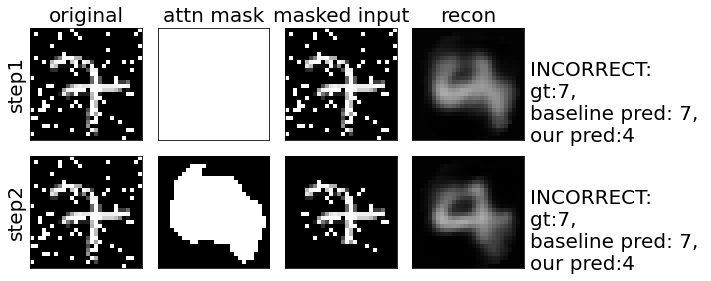

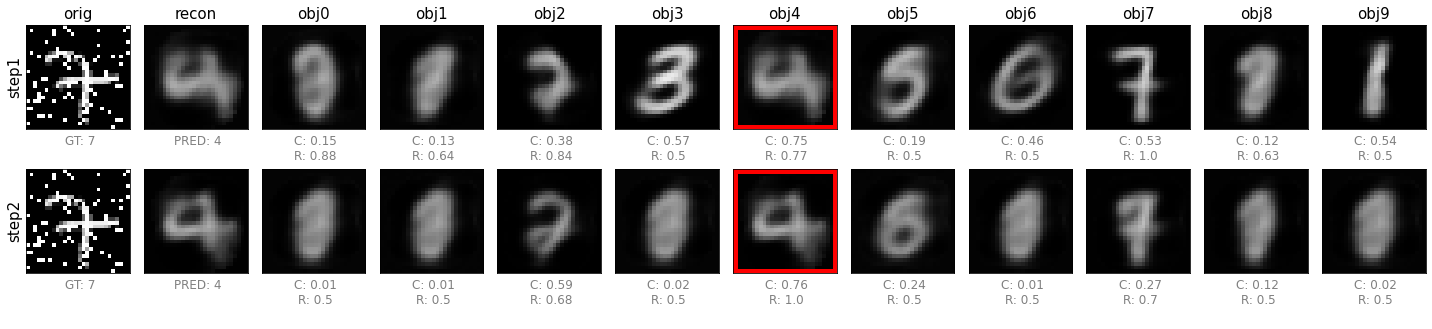



================ TRIAL 6 ===================


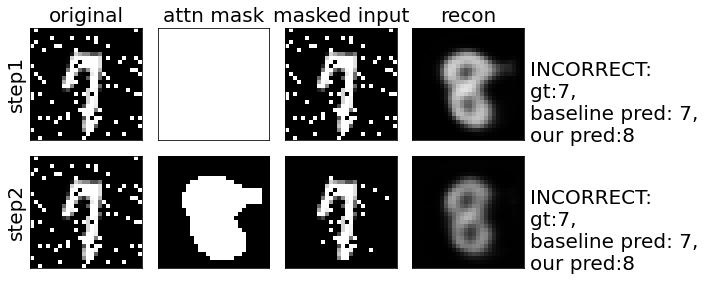

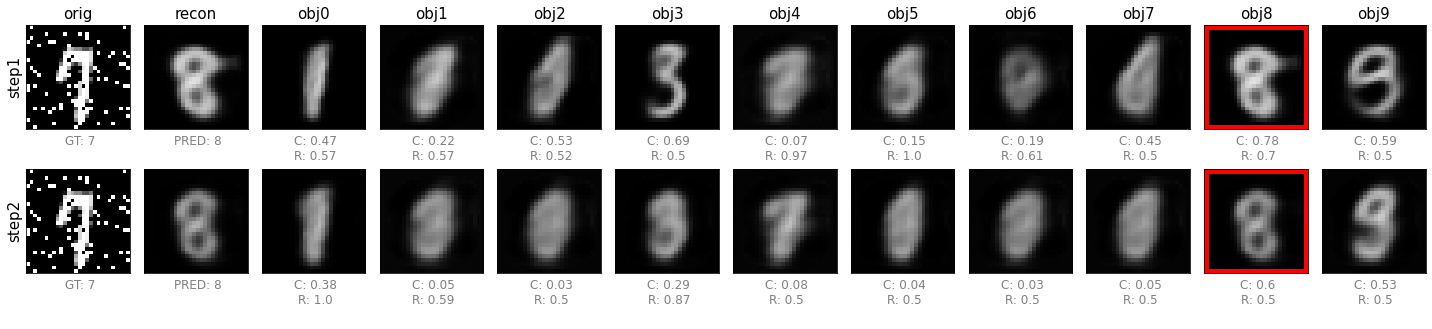



================ TRIAL 18 ===================


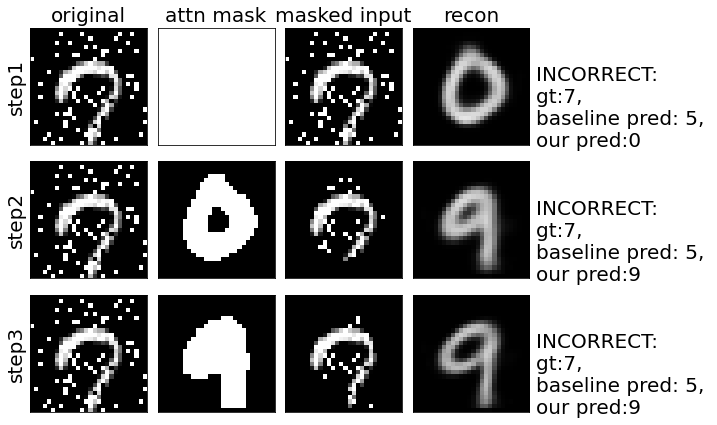

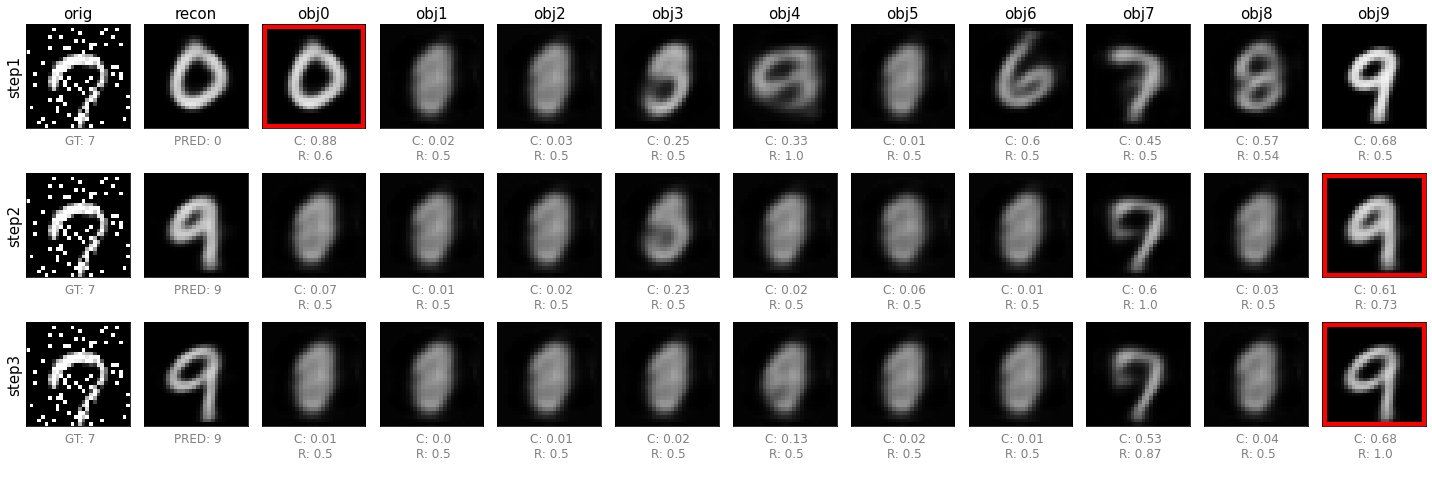



================ TRIAL 20 ===================


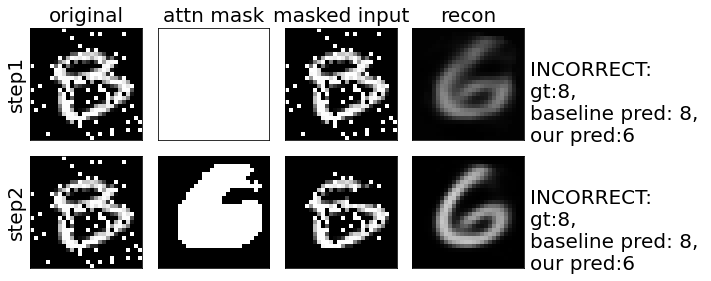

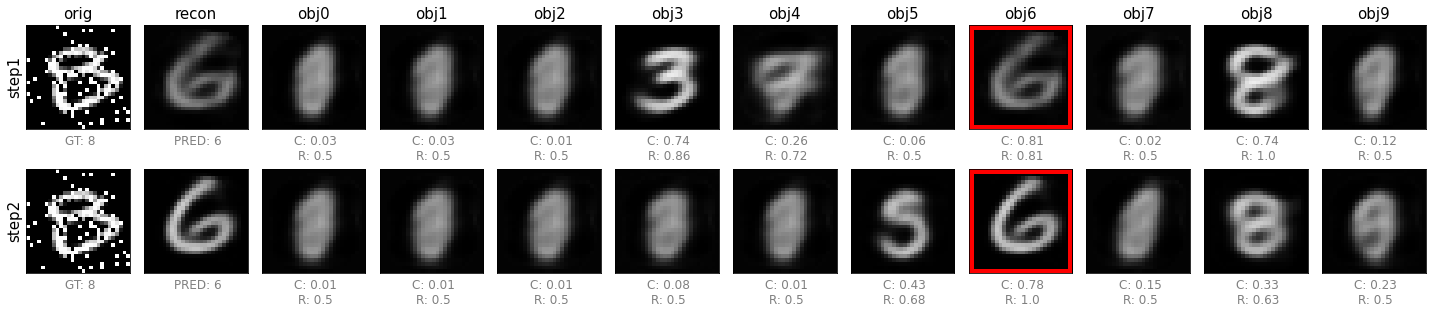



================ TRIAL 25 ===================


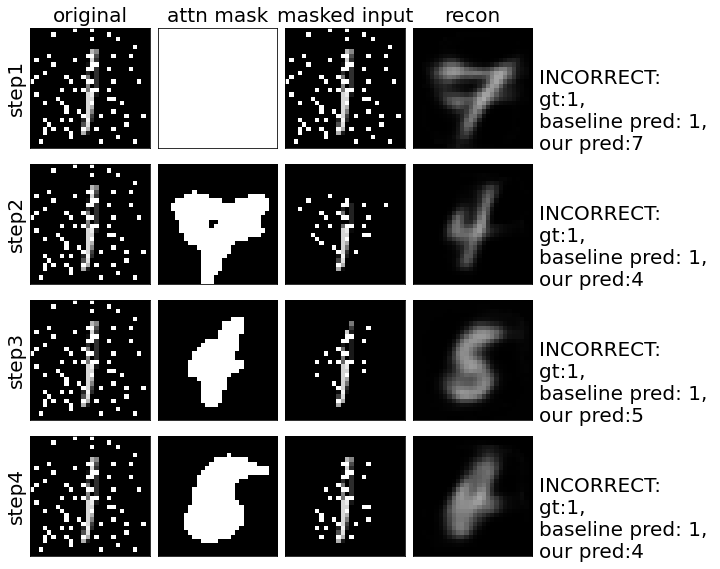

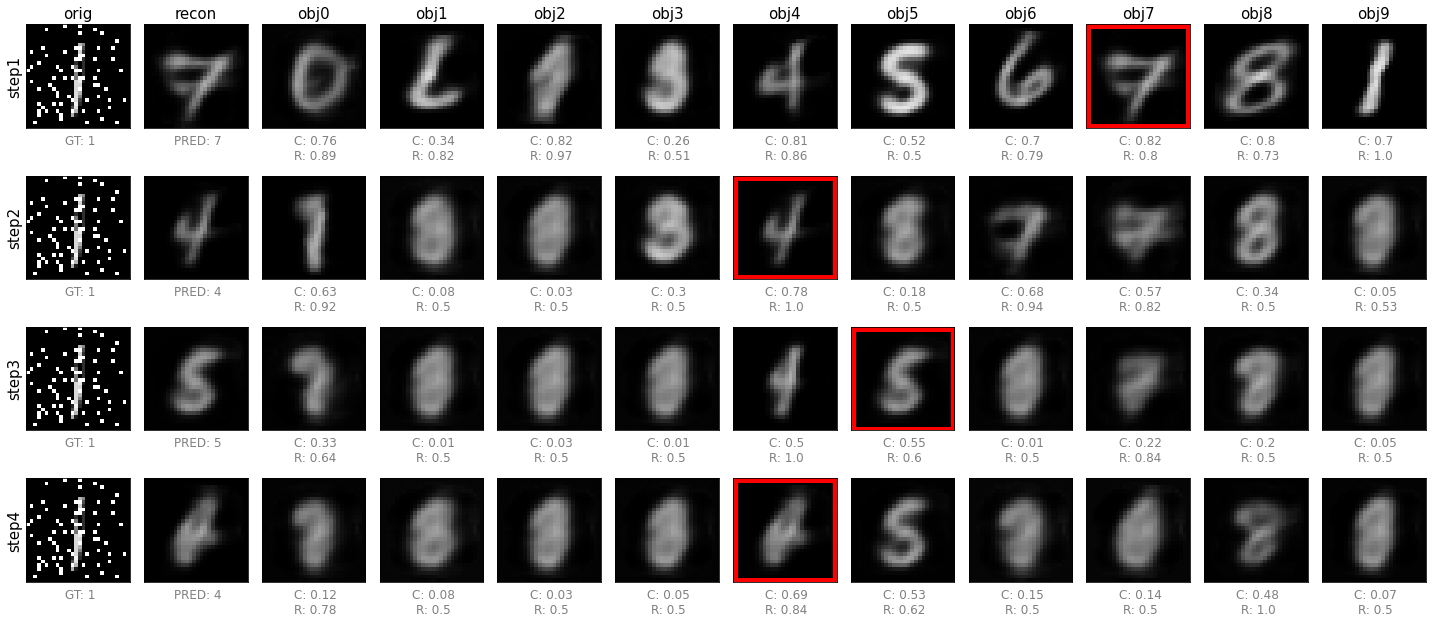



================ TRIAL 29 ===================


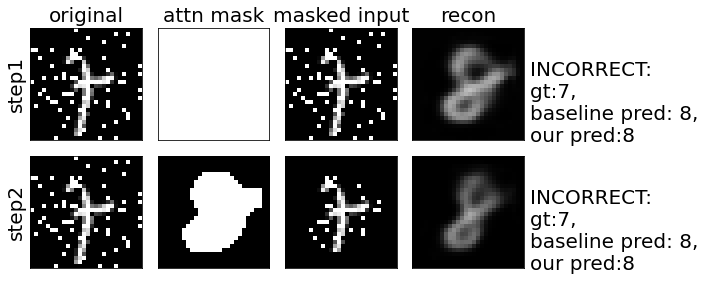

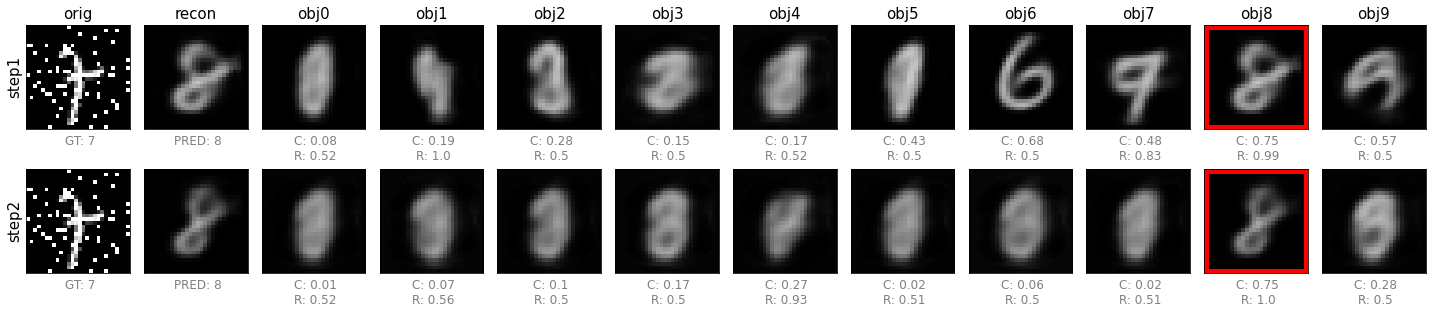



================ TRIAL 44 ===================


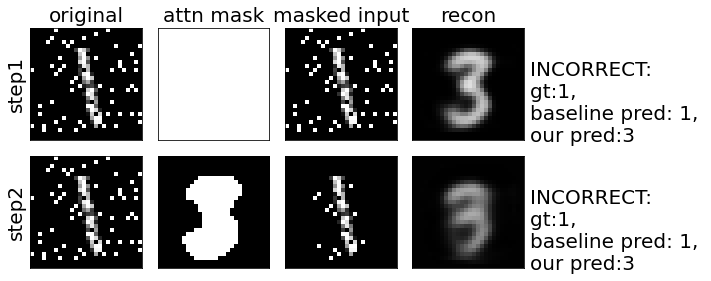

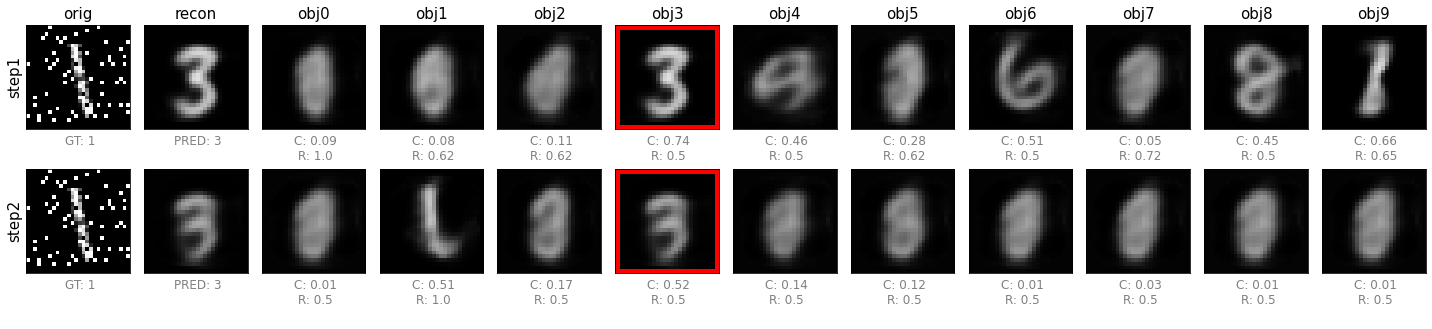



================ TRIAL 66 ===================


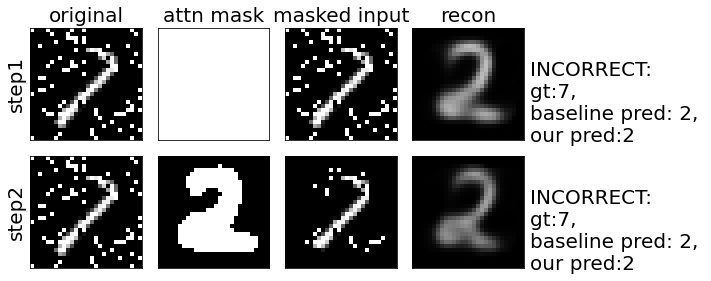

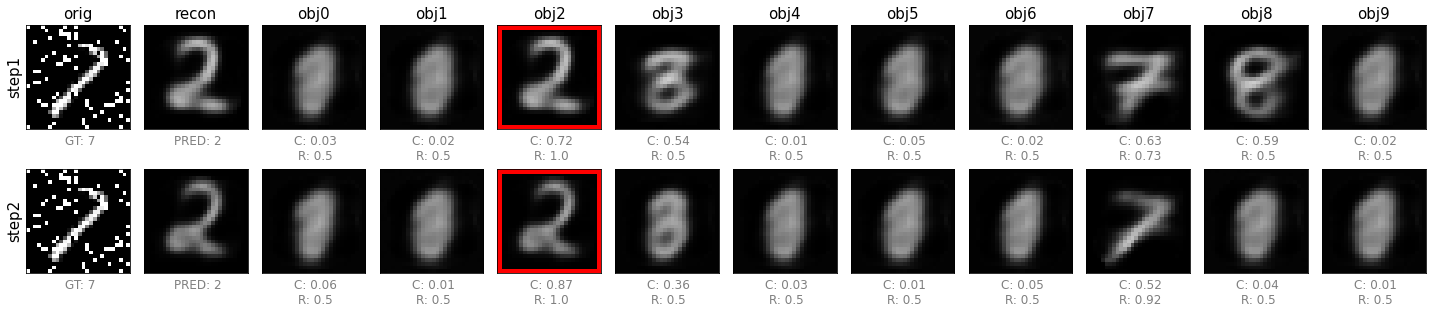



================ TRIAL 85 ===================


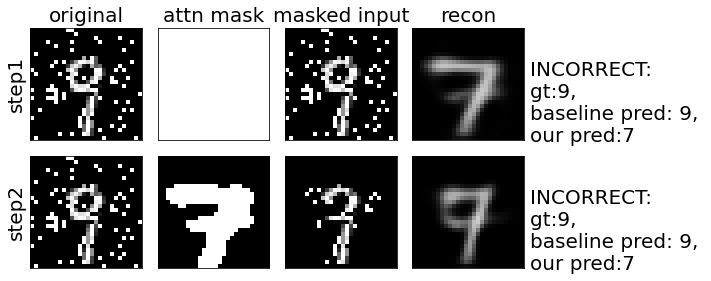

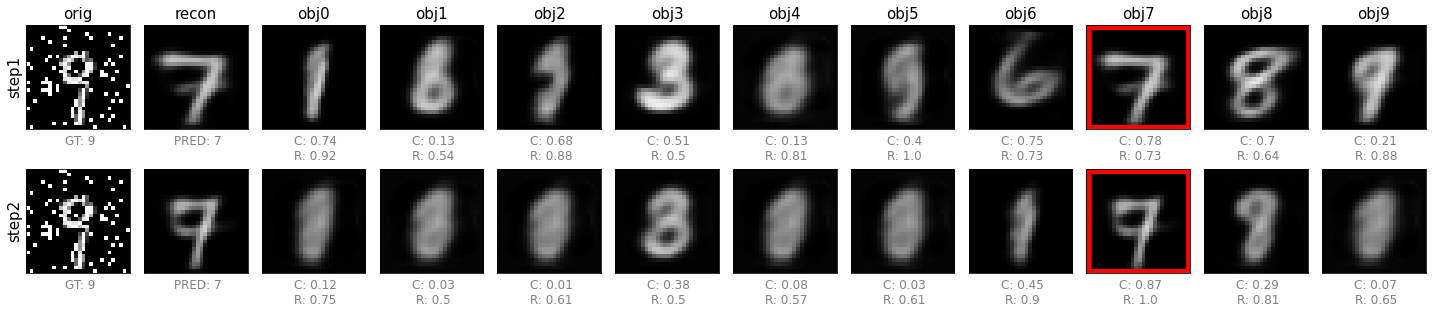



================ TRIAL 87 ===================


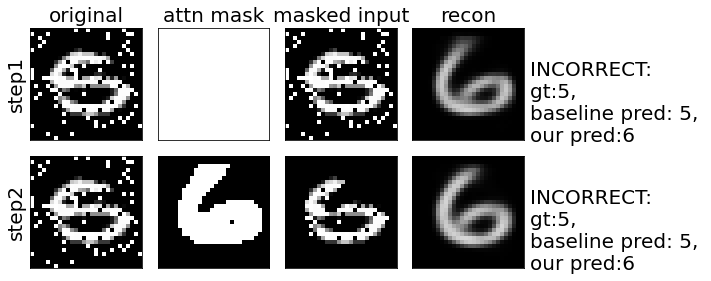

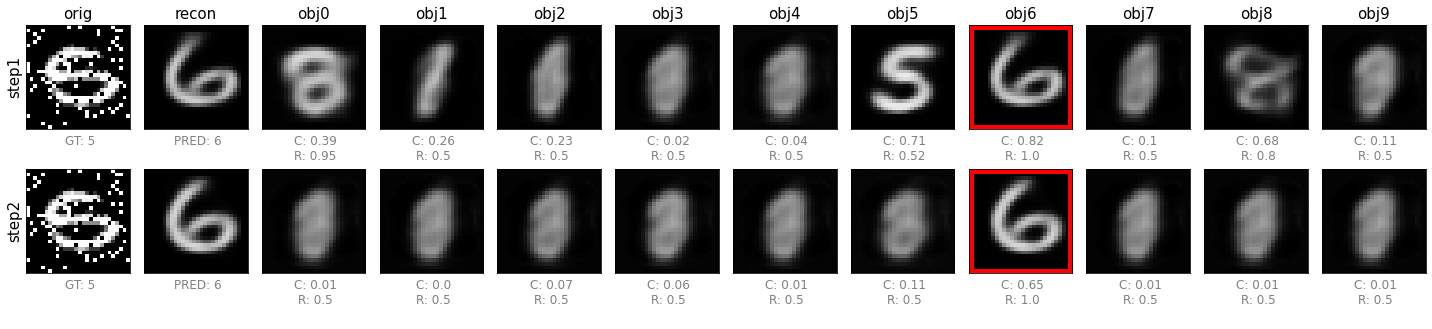



================ TRIAL 92 ===================


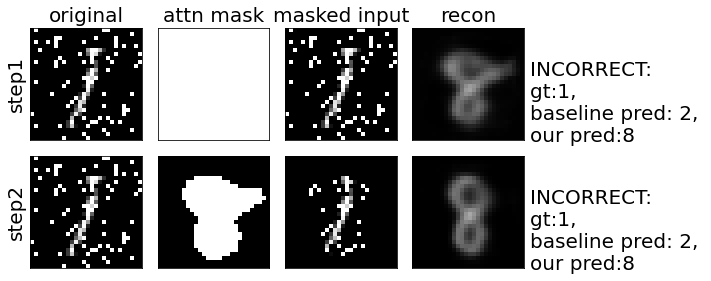

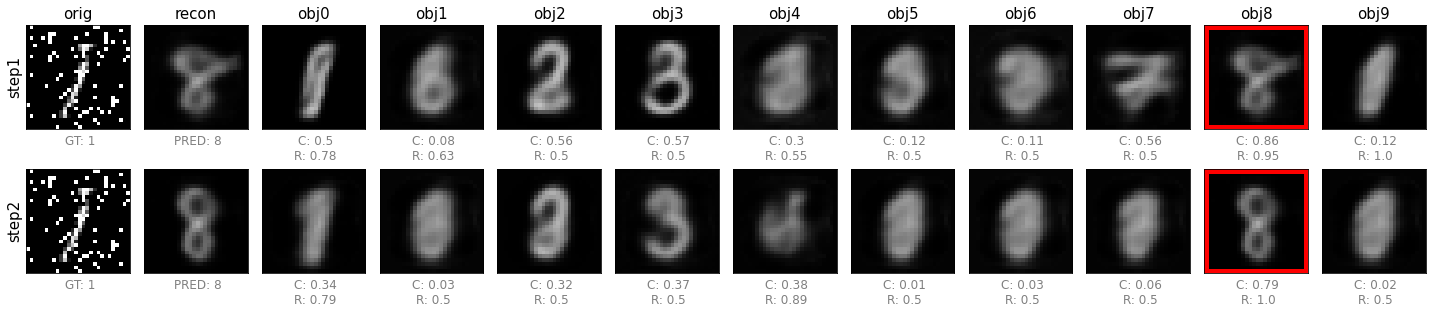



================ TRIAL 97 ===================


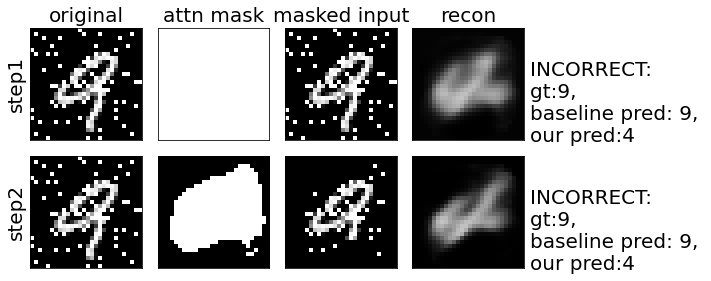

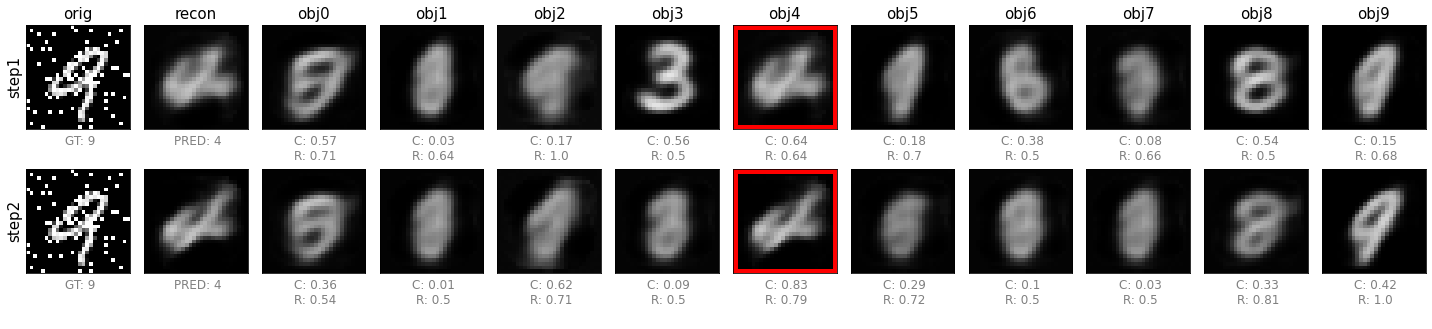



================ TRIAL 107 ===================


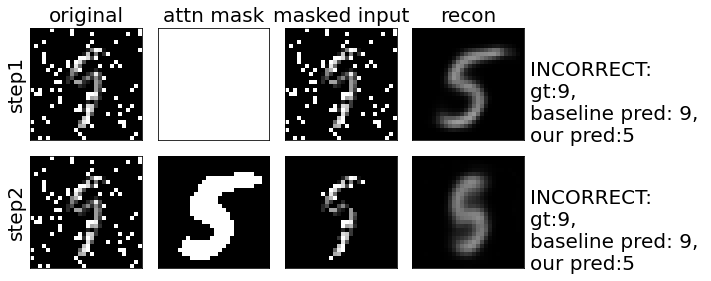

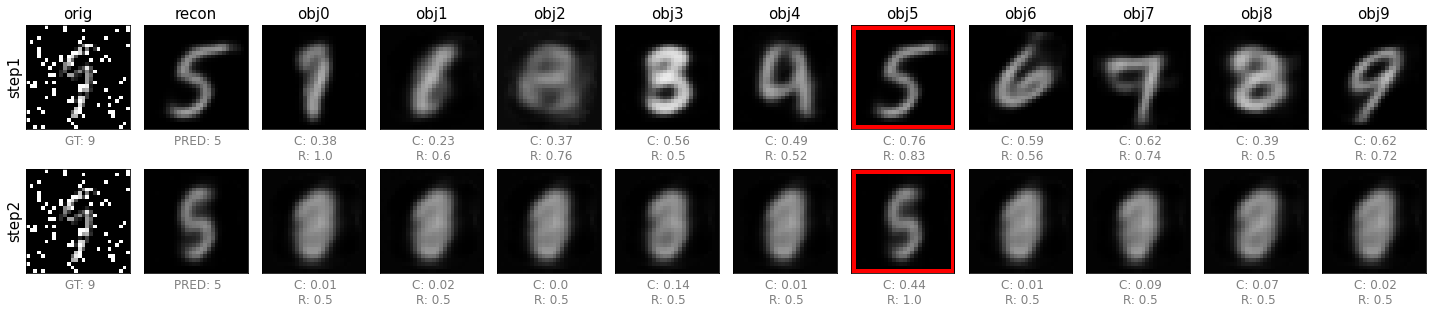



================ TRIAL 114 ===================


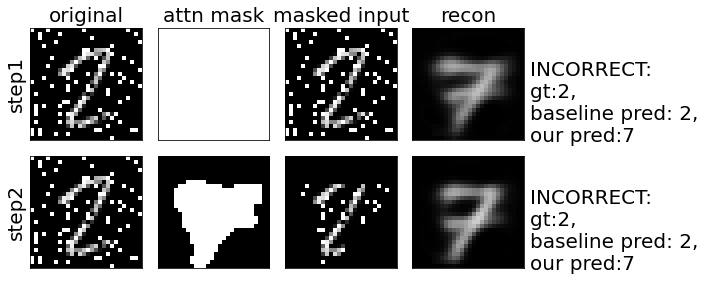

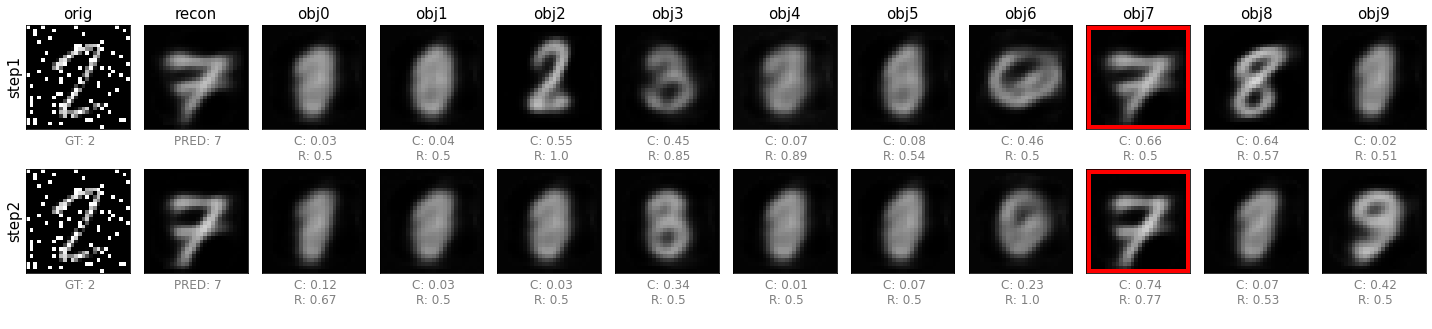



================ TRIAL 122 ===================


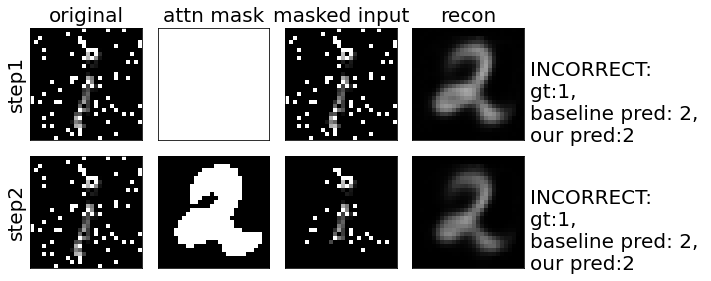

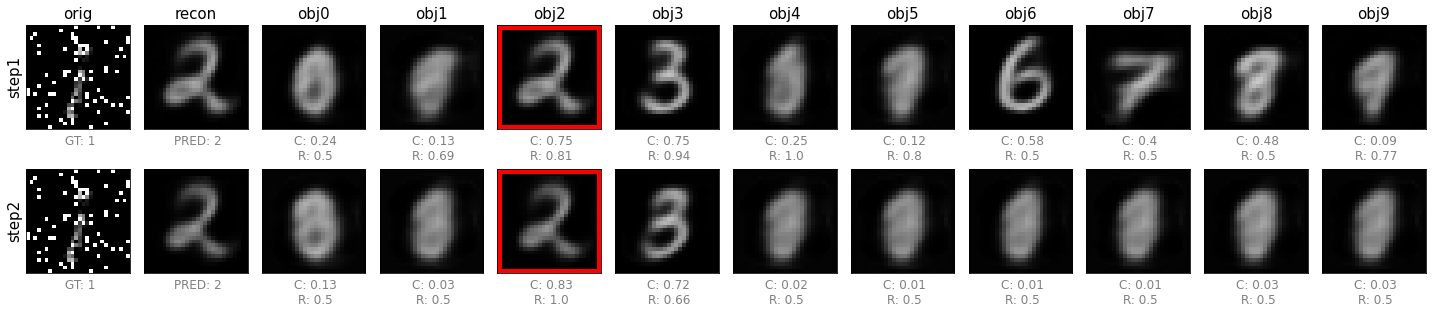



================ TRIAL 123 ===================


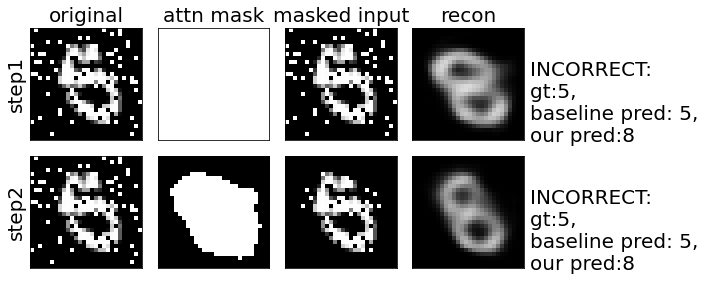

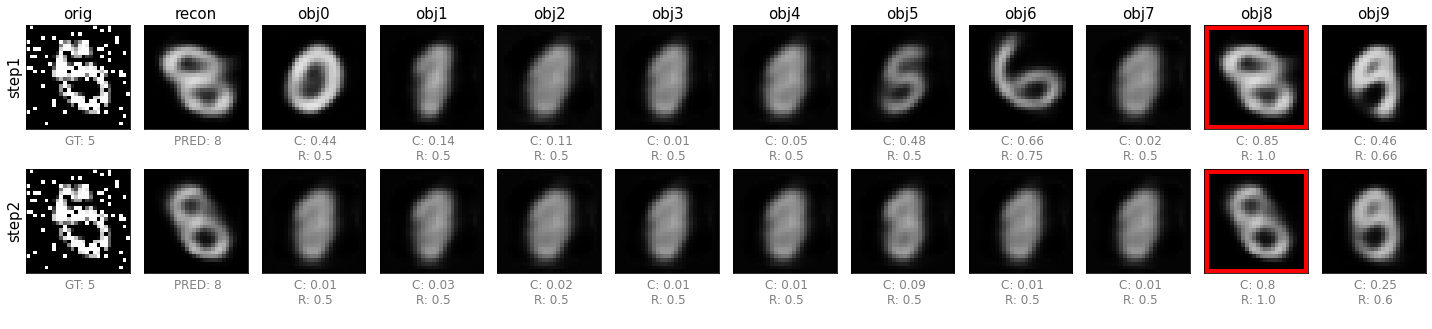



================ TRIAL 136 ===================


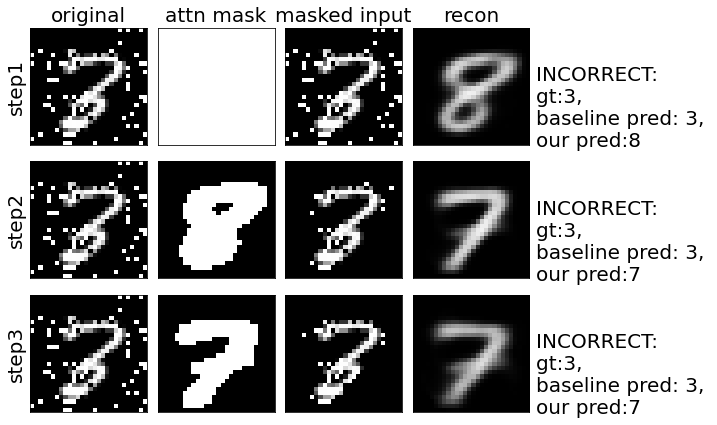

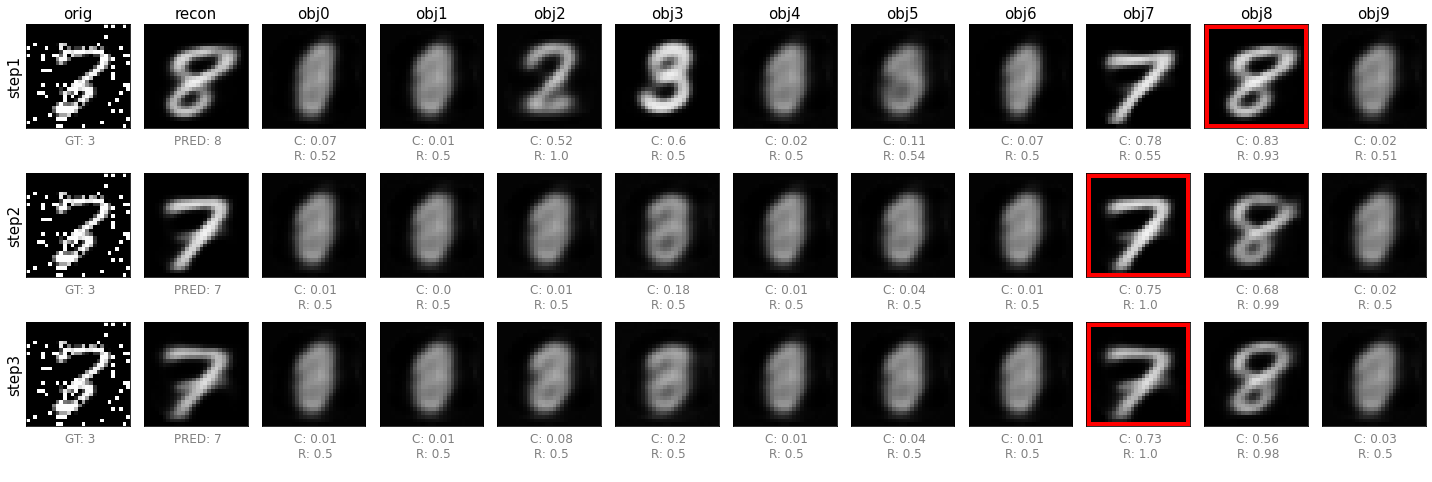



================ TRIAL 168 ===================


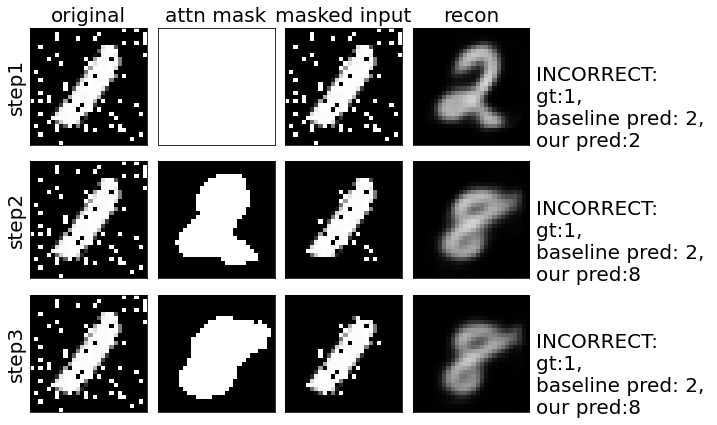

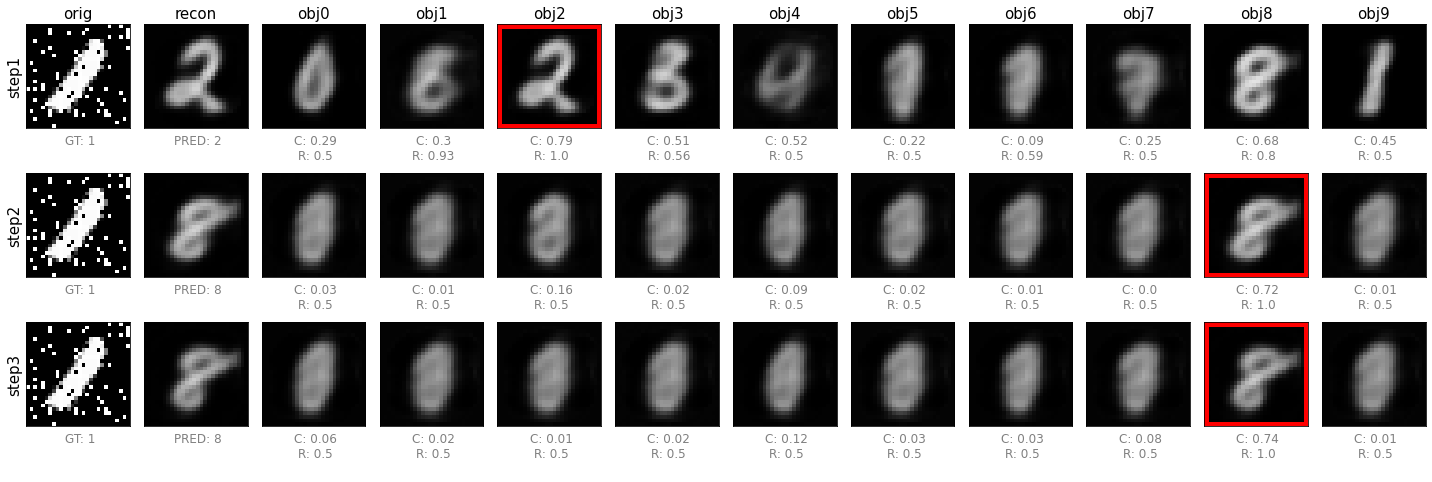



================ TRIAL 187 ===================


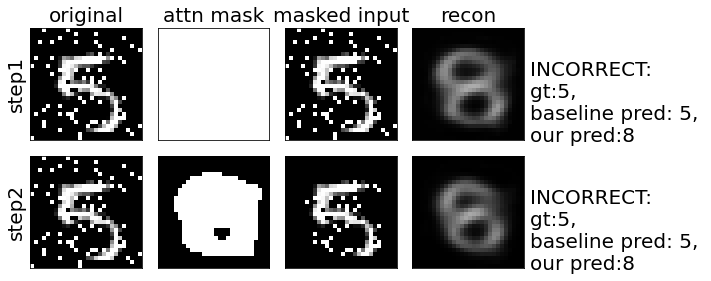

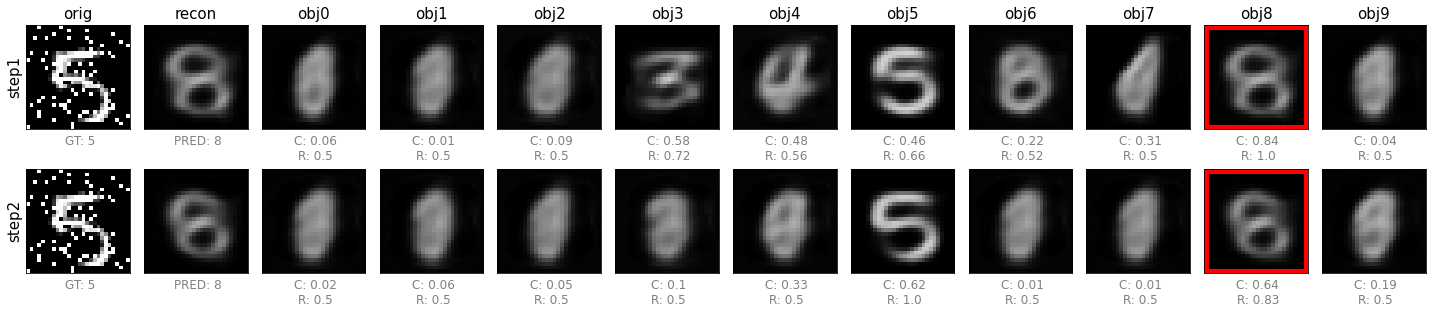



================ TRIAL 193 ===================


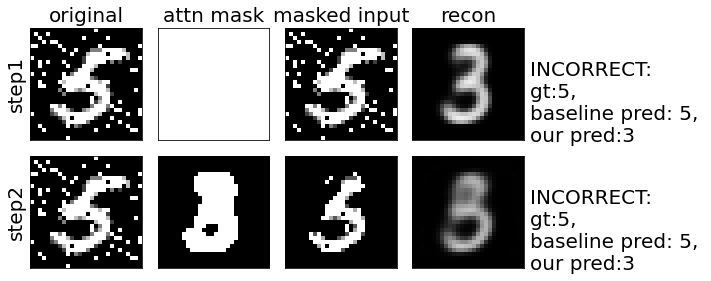

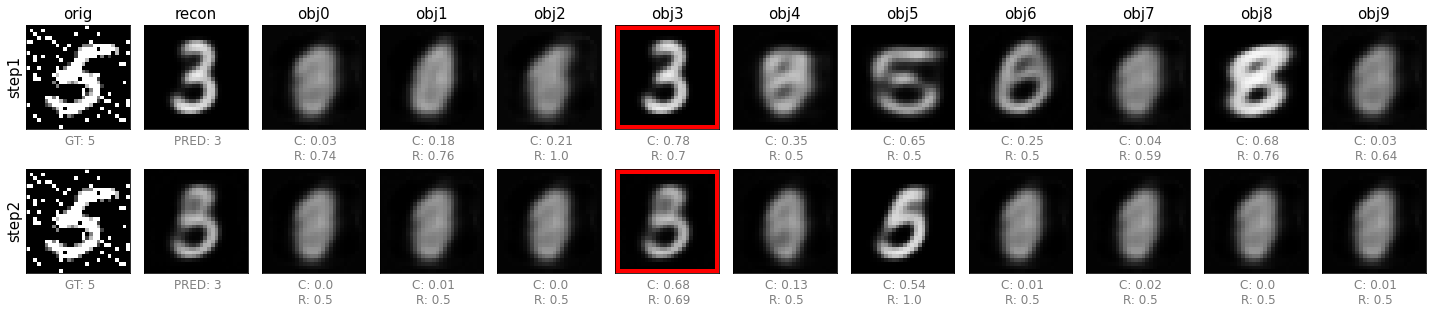



================ TRIAL 204 ===================


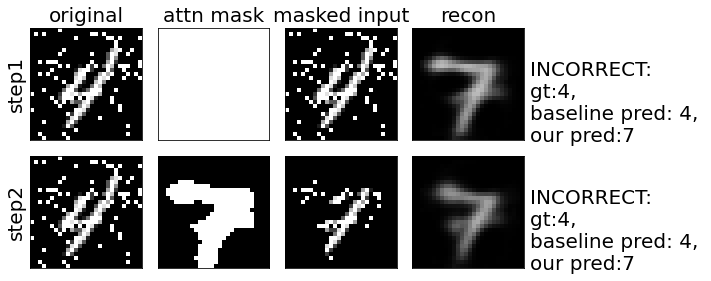

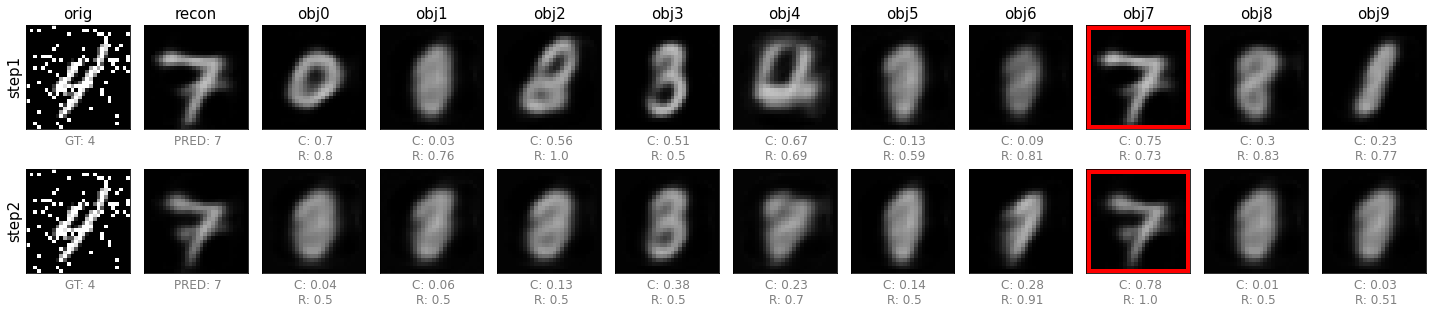



================ TRIAL 224 ===================


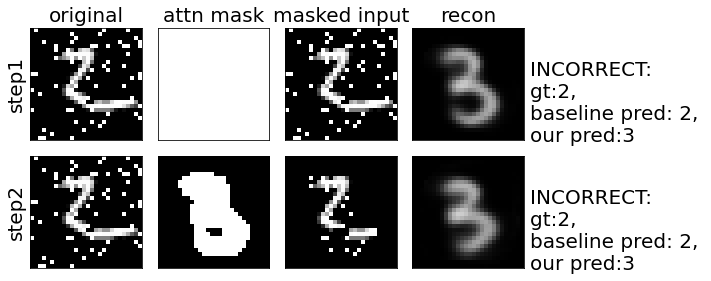

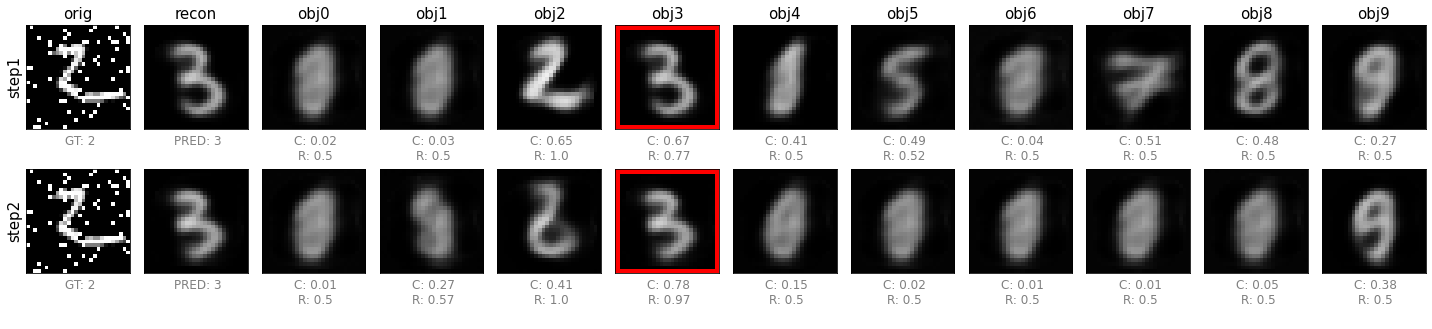



================ TRIAL 229 ===================


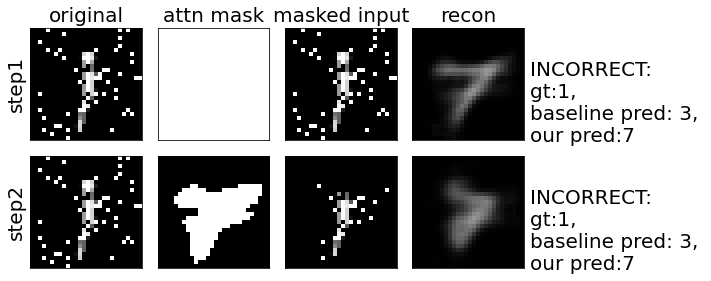

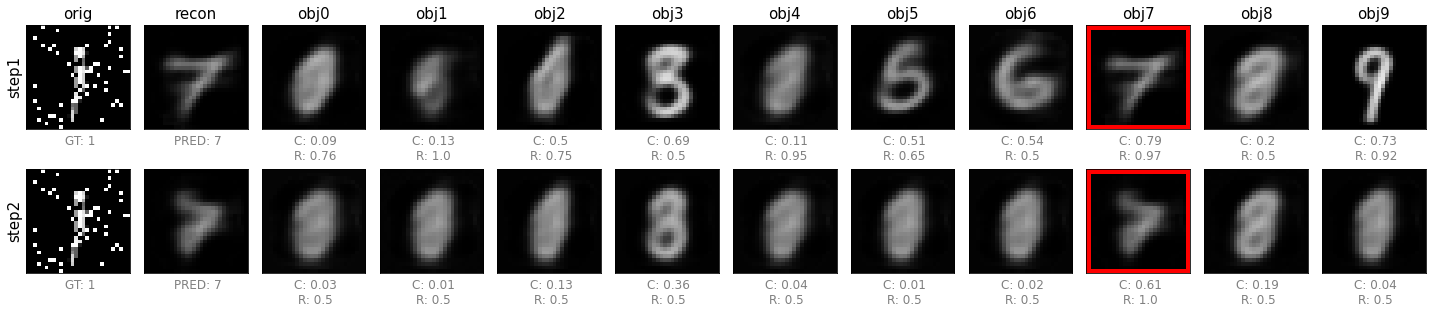



================ TRIAL 281 ===================


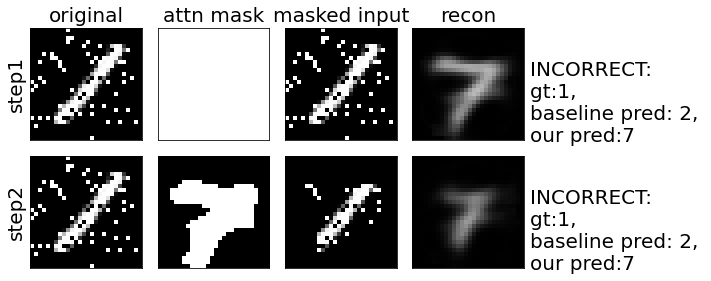

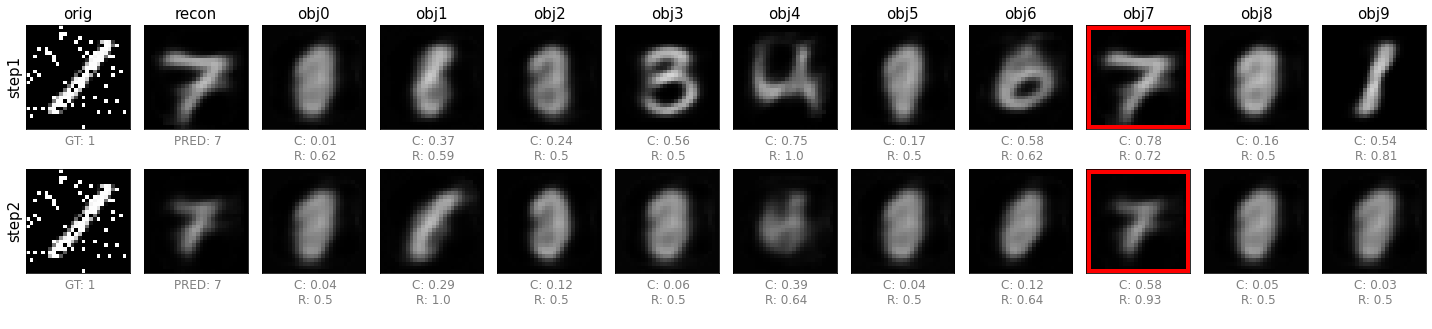



================ TRIAL 307 ===================


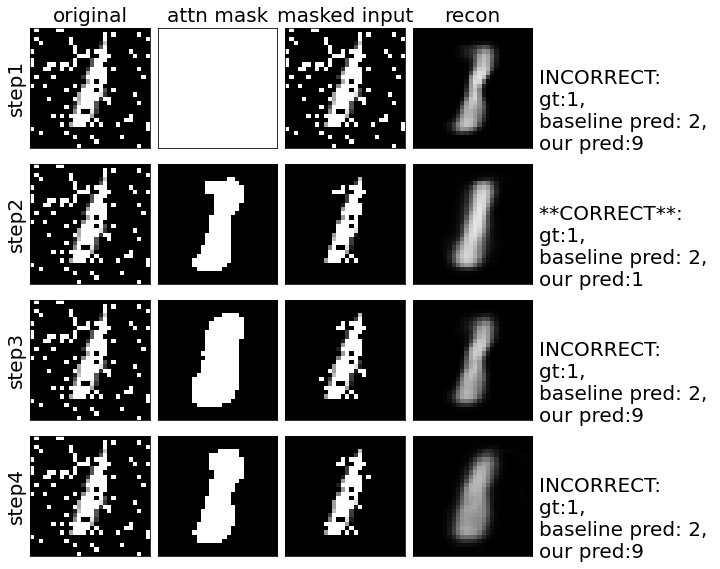

KeyboardInterrupt: 

In [18]:
###################################
# stepwise visualization
###################################
idx_start = 0 # can't be higher than batchsize
n_image =2000



condition = 'first correct last incorrect'
condition = 'first incorrect last correct'
# condition = 'first incorrect last incorrect'
condition = 'all'
# condition = 'correct'
condition = 'incorrect' 

# condition = [6, 41, 66]
# condition = [7, 11]
# condition = [66, 114, 656] #batchnum1
# condition = [6] #batchnum2
# condition = [6] #batchnum3
# condition = [17]
# condition = [8] #batchnum 3
# condition = [22, 33,41,44,75,82,88,147] #fog batch
# condition = [6,7]
# condition = [17]
# condition = [447]
# condition = [167, 502, 1466]

# condition = trialid_to_visualize #[:20]
# condition = list(np.where(nstep==3)[0])
# condition = [309]
# condition = [560, 893]
# condition=[7]
# condition=[82, 92]

visualize_detail(model, x.to(DEVICE), y_hot, outputs_model, 
                 x_recon_step, objcaps_len_step, args,
                 start=idx_start, n_image=n_image, plot_trials_when = condition,
                 plot_routings=False, 
                 pred_to_compare=pred_cnn, num_steps_to_finish=list(nstep), 
                 only_plot_object=None)

In [ ]:
#################################
# if you need separate visualization for each output 
##################################
idx_start = 40 # can't be higher than batchsize
n_image =10

print("\n\n=========================== reconstruction =================================")
visualize_batch(x, y, x_recon_step, objcaps_len_step, include_sum=False, start=idx_start, n_image=n_image)

print("\n\n=========================== reconstruction mask =================================")
visualize_batch(x, y, outputs['x_mask'], objcaps_len_step, start=idx_start, n_image=n_image)

print("\n\n=========================== masked input =================================")
visualize_batch(x, y, outputs['x_input'], objcaps_len_step, start=idx_start, n_image=n_image)

In [ ]:
# # plot and save image outputs
# from torchvision.utils import save_image, make_grid
# import matplotlib.pyplot as plt

# n_image = 50
# plot_save_dir = None
# img_grid = torch.cat((x[:n_image].to(args.device),torch.sum(x_recon_step,dim=1)[:n_image]))
# img_grid = make_grid(img_grid, nrow=10, padding=1, normalize=False, pad_value=1)

# if plot_save_dir:
#     model_name = args.log_dir.split('/')[-1]
#     save_name = f'final_reconstruction_{model_name}.png'
#     save_image(img_grid, os.path.join(plot_save_dir, save_name))

# # img_g = Image.open(os.path.join(args.output_dir, save_name))
# # f = plt.figure()
# # f.set_figheight(15)
# # f.set_figwidth(15)
# plt.imshow(img_grid.cpu()[], cmap='gray_r') #matplot imshow() WILL AUTO CHANGE ONE CHANNEL IMG TO COLOR ONE
# plt.show()

# def show_reconstruction(model, test_loader, n_images, args):
#     import matplotlib.pyplot as plt
#     from utils import combine_images
#     from PIL import Image
#     import numpy as np

#     model.eval()
#     for x, _ in test_loader:
#         x = Variable(x[:min(n_images, x.size(0))].cuda(), volatile=True)
#         _, x_recon = model(x)
#         data = np.concatenate([x.data, x_recon.data])
#         img = combine_images(np.transpose(data, [0, 2, 3, 1]))
#         image = img * 255
#         Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
#         print()
#         print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
#         print('-' * 70)
#         plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png", ))
#         plt.show()
#         break
        
# # https://medium.com/@sergioalves94/deep-learning-in-pytorch-with-cifar-10-dataset-858b504a6b54
# from torchvision.utils import make_grid

# for images, _ in train_loader:
#     print('images.shape:', images.shape)
#     plt.figure(figsize=(16,8))
#     plt.axis('off')
#     plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
#     break

# Generate Detailed Acc Results on MNIST-C

In [5]:
########################################################
# best model comparison on entire corruptions
########################################################
verbose=False
print_args =False
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 
                 'time_steps': 4, 'routings': 3, 'mask_threshold': 0.1}


modelpathlist = [
# './models/rrcapsnet/run1_epoch50_acc0.9917.pt',
# './models/rrcapsnet/run2_epoch50_acc0.9915.pt',
# './models/rrcapsnet/run3_epoch50_acc0.9907.pt',
# './models/rrcapsnet/run4_epoch50_acc0.9905.pt',
# './models/rrcapsnet/run5_epoch50_acc0.9907.pt',

# './results/mnist/Apr28_1352_adam_clr_128/archive_model_epoch50_acc0.9987.pt'
# './results/mnist/Apr28_1408_adam_clr_512/archive_model_epoch50_acc0.9953.pt' # increase bn worse
# './results/mnist/Apr28_1438_adam_clr_128_wde5/archive_model_epoch50_acc0.9986.pt'
# './results/mnist/Apr28_1458_adam_clr_128_wde4/archive_model_epoch50_acc0.9963.pt' #incerase weigthday worse
# './results/mnist/Apr28_1550_adamw_clr_128/archive_model_epoch50_acc0.9988.pt'
# './results/mnist/Apr28_1626_rmsprop_clr_128/archive_model_epoch50_acc0.9936.pt'
# './results/mnist/Apr28_1641_adam_exp_128/archive_model_epoch50_acc0.9979.pt'
# './results/mnist/Apr28_1719_adam_exp_128_lre3/archive_model_epoch50_acc0.9982.pt'
# './results/mnist/Apr28_1745_adam_exp_128_lre3_lamrecon5/archive_model_epoch50_acc0.9986.pt'
# './results/mnist/Apr28_1815_capsnetencoder_cycle/archive_model_epoch220_acc0.9961.pt'

# './results/mnist/Apr28_2001_shift_adamclr/archive_model_epoch50_acc0.9860.pt'

# Clean-CLR
# './results/mnist/Apr29_0212_clean_clr_run1/best_epoch174_acc0.9993.pt',
# './results/mnist/Apr29_0321_clean_clr_run2/best_epoch163_acc0.9993.pt',
# './results/mnist/Apr29_0427_clean_clr_run3/best_epoch186_acc0.9994.pt',
# './results/mnist/Apr29_0540_clean_clr_run4/best_epoch212_acc0.9995.pt',
# './results/mnist/Apr29_0703_clean_clr_run5/earlystop_245_acc0.9995.pt',
    
# Clean-WD
'./results/mnist/Apr29_0213_clean_wd_run1/best_epoch75_acc0.9981.pt',
'./results/mnist/Apr29_0247_clean_wd_run2/best_epoch81_acc0.9987.pt',
'./results/mnist/Apr29_0322_clean_wd_run3/best_epoch88_acc0.9987.pt',
'./results/mnist/Apr29_0400_clean_wd_run4/best_epoch62_acc0.9980.pt',
'./results/mnist/Apr29_0429_clean_wd_run5/best_epoch71_acc0.9987.pt',
]



df = pd.DataFrame()
df['corruption'] = CORRUPTION_TYPES

for load_model_path in modelpathlist:    
#     modelname = '-'.join( os.path.dirname(load_model_path).split('_')[-3:-1]) #'recon-step3'
    modelname = load_model_path.split('/')[-1] # filename
    print(f'test starts on {modelname}')
    
    # load args and model  
    args = load_args(load_model_path, args_to_update, print_args)
    model = load_model(args)
    
    acclist = []
    for corruption in CORRUPTION_TYPES:
        test_loss, test_loss_class, test_loss_recon, test_acc = test_model_on_each_corruption(PATH_MNISTC, corruption, model, verbose)
        acclist.append(test_acc*100)
    df[load_model_path] = acclist


df.index = np.arange(1, len(df)+1)
df.loc['AVERAGE'] = df.mean()
df

test starts on best_epoch75_acc0.9981.pt

=========== model instantiated like below: =============
TASK: mnist (# targets: 1, # classes: 10, # background: 0)
TIMESTEPS #: 4
ENCODER: two-conv-layer w/ None projection
...resulting primary caps #: 1152, dim: 8
ROUTINGS # 3
Object #: 10, BG Capsule #: 0
DECODER: fcn, w/ None projection
...recon only one object capsule: True
...use recon mask for attention: True
...with mask type bool, threshold 0.1, apply_method match

test starts on best_epoch81_acc0.9987.pt

=========== model instantiated like below: =============
TASK: mnist (# targets: 1, # classes: 10, # background: 0)
TIMESTEPS #: 4
ENCODER: two-conv-layer w/ None projection
...resulting primary caps #: 1152, dim: 8
ROUTINGS # 3
Object #: 10, BG Capsule #: 0
DECODER: fcn, w/ None projection
...recon only one object capsule: True
...use recon mask for attention: True
...with mask type bool, threshold 0.1, apply_method match

test starts on best_epoch88_acc0.9987.pt

=========== model 

/tmp/ipykernel_621445/2432561113.py:67: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.loc['AVERAGE'] = df.mean()


,corruption,./results/mnist/Apr29_0213_clean_wd_run1/best_epoch75_acc0.9981.pt,./results/mnist/Apr29_0247_clean_wd_run2/best_epoch81_acc0.9987.pt,./results/mnist/Apr29_0322_clean_wd_run3/best_epoch88_acc0.9987.pt,./results/mnist/Apr29_0400_clean_wd_run4/best_epoch62_acc0.9980.pt,./results/mnist/Apr29_0429_clean_wd_run5/best_epoch71_acc0.9987.pt
1,identity,99.020004,99.090006,99.120004,99.040005,99.070004
2,shot_noise,93.530005,93.590004,94.220004,92.750005,93.200005
3,impulse_noise,89.160005,91.670005,89.870004,90.710005,91.900005
4,glass_blur,84.940004,80.630004,85.350004,83.720004,81.980004
5,motion_blur,93.460005,92.530004,94.880005,94.410004,91.880004
6,shear,97.550004,97.790005,97.940004,97.650005,97.590004
7,scale,94.630005,94.970004,94.830005,94.950005,93.980005
8,rotate,91.750004,91.760004,92.280004,91.730005,92.210004
9,brightness,98.620004,98.600004,98.580005,98.600004,98.500005
10,translate,48.520002,48.950002,50.910002,49.140002,49.710003


In [6]:
# save to csv
# path_df = 'model-results-rrcapsnet-clean-G4L3.csv'
path_df = 'model-results-rrcapsnet-clean-G4L3-wd.csv'

overwrite = True
if os.path.isfile(path_df) and not overwrite:
    print(f'test done! file {path_df} already exists, df is not saved')
else: 
    df.to_csv(path_df, index=False)
    print(f'test done! df is saved to csv as {path_df}')

test done! df is saved to csv as model-results-rrcapsnet-clean-G4L3-wd.csv


# Analyze models under the experiment root folder
obtain best model from each experiment and compare overall accuracy
- all pretrained models to be compared should be saved under the same folder 
- output is df file and will be saved to csv

In [3]:
##################
# set up info for model testing
##################
task='mnist_recon' #train on mnist_recon, test on mnistc_mini
task='mnist_c' #test on 15 benchmark corruption + 1 identity 

# get best model files under experiment path
path_experiment = './results/mnist/experiment-recon-norecon'
bestfiles, expnames = get_bestmodel_paths(path_experiment)
expname_format = ['use_recon','n_step', 'seed'] # what's writte n after timestamp
# expname_format = ['use_recon','n_step', 'inputmatch', 'seed']

# arguments to update
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 
                 'time_steps': 4, 'routings': 3, 'routing_type': 'pd-recon', #'original' 
                 'min_coup': 0.5, 'min_rscore': 0.5, 'mask_threshold': 0.1}
print_args =False


##################
# main - model testing
##################

# create dataframe
df = pd.DataFrame()
df['model_path'] = bestfiles
df['exp_name'] = expnames
df[expname_format] = df['exp_name'].str.split('_',expand=True)
df['exp_name'] = df['exp_name'].str.split('_').str[:-1].str.join('_') #expname without seed

for i, row in df.iterrows():
    print(f'test begin on {i+1}th model')

    # load model
    load_model_path = row['model_path']   
    args = load_args(load_model_path, args_to_update, print_args)
    model = load_model(args)

    # test model
    if task == 'mnist_c':
        df.loc[i,'test_loss'], df.loc[i,'test_loss_class'], df.loc[i,'test_loss_recon'], df.loc[i,'test_acc'] = test_model_mnistc(PATH_MNISTC, CORRUPTION_TYPES, model)
    else:
        df.loc[i,'test_loss'], df.loc[i,'test_loss_class'], df.loc[i,'test_loss_recon'], df.loc[i,'test_acc'] = test_model(task, model, args)
    #     test_loss, test_loss_class, test_loss_recon, test_acc = test_model(model,args)
    
print('========== tests are done =============')

# save df
path_savefile = task + '-'+ os.path.basename(path_experiment) + '.csv'
if os.path.isfile(path_savefile):
    print(f'csv file already exists: {path_savefile}')
else: 
    df.to_csv(path_savefile)
    print(f'csv file saved: {path_savefile}')